In [1]:
import os
import time
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import pathlib
import numpy as np
import factory
import birdDataset
from utils.utility import *
from tqdm import tqdm
from torchsummary import summary

#shift+alt+F -> for auto formatting

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

inference_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

classes = []

In [2]:
def getClasses():
    tmp_path = str(pathlib.Path().resolve())
    lines = []
    classes = []

    with open(tmp_path + '\classes.txt') as f:
        lines = f.readlines()

    for line in lines:
        #pos = line.find('.')
        classes.append(line[:-1])
        
    return classes

In [3]:
def get_img_name(img_dir, format="jpg"):
    """
    獲取資料夾下format格式的檔名
    :param img_dir: str
    :param format: str
    :return: list
    """
    file_names = os.listdir(img_dir)
    # 使用 list(filter(lambda())) 篩選出 jpg 字尾的檔案
    img_names = list(filter(lambda x: x.endswith(format), file_names))

    if len(img_names) < 1:
        raise ValueError("{}下找不到{}格式資料".format(img_dir, format))
    return img_names



In [4]:
def train(model, criterion, optimizer, dataloader, switch='Eval', epoch=1):
    train_list = []
    model = model.to(device)
    if(switch == 'Train'):
        model.train()
    elif(switch == 'Valid'):
        model.eval()
    elif(switch == 'Test'):
        model.eval()
    else:
        model.eval()
    while(epoch):
        total_loss = 0.0
        accTop1 = 0
        accTop5 = 0
        for i_batch, data in tqdm(enumerate(dataloader)):
            image = data[0].to(device)
            label = data[1].to(device)
            output = model(image)

            accTop = evaluteAcc(output, label, topk=(1, 5))
            accTop1 += accTop[0]
            accTop5 += accTop[1]

            loss = criterion(output, label)

            if(switch == 'Train'):
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            #total_loss += loss.detach().cpu()
            #print(loss.detach().cpu())
        
        total_loss /= (i_batch + 1)
        accTop1 /= (i_batch + 1)
        accTop5 /= (i_batch + 1)
        epoch -= 1

    return total_loss, accTop1, accTop5

In [5]:
def run_image_classification(model, image_path, transform, classes, topk=5):
    """Inference
    """
    testing_dir = 'testing_images\\'
    testing_seq = 'testing_img_order.txt'
    testing_output = 'output/answer.txt'
    fo = open(testing_output, 'w')
    i = 0
    model = model.to(device)
    model.eval()
    with open(testing_seq) as f:
            lines = f.readlines()

            for line in lines:
                i = i+1
                if(i == 10):
                    pass
                # Read image and run prepro
                image = Image.open(testing_dir + line[:-1]).convert("RGB")
                image_tensor = transform(image)
                print(f"\n\nImage size after transformation: {image_tensor.size()}")

                image_tensor = image_tensor.unsqueeze(0)
                print(f"Image size after unsqueezing: {image_tensor.size()}")

                #test
                image_tensor = image_tensor.to(device)

                # Feed input
                output = model(image_tensor)
                print(f"Output size: {output.size()}")

                output = output.squeeze()
                print(f"Output size after squeezing: {output.size()}")

                # Result postpro
                _, indices = torch.sort(output, descending=True)
                probs = F.softmax(output, dim=-1)

                fo.write(line[:-1] + ' ' + classes[indices[0]] + '\n')
                '''
                print("\n\nInference results:")
                for index in indices[:topk]:
                    print(f"Label {index}: {classes[index]} ({probs[index].item():.2f})")
                '''
    fo.close()

    return


In [6]:
def evaluteAcc(y_pred, y, topk=(1,)):
    maxk = max(topk)

    _, pred = y_pred.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y.view(1, -1).expand_as(pred))
    #print(correct)

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k)
    return res

In [7]:
def cross_valid(model=None,criterion=None,optimizer=None,dataset=None,k_fold=10, batch_size=10):

    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    train_loss = 0.0
    val_loss =0.0
    train_list = []
    val_list = []
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        # msg
        print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
               % (trll,trlr,trrl,trrr,vall,valr))
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=False)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False)
        train_loss, train_acc_top1, train_acc_top5 = train(model, criterion, optimizer, train_loader, switch='Train', epoch=1)
        print('train - loss: ' + str(train_loss) + '\t, top1: ' + str(train_acc_top1.cpu()/batch_size) + '\t, top5: ' + str(train_acc_top5.cpu()/batch_size))
        #train_score.at[i] = train_acc
        val_loss, valid_acc_top1, valid_acc_top5 = train(model,criterion,optimizer,val_loader, switch='Valid')
        print('valid - loss: ' + str(val_loss) + '\t, top1: ' + str(valid_acc_top1.cpu()/batch_size) + '\t, top5: ' + str(valid_acc_top5.cpu()/batch_size))
        #val_score.at[i] = val_acc
        train_list.append(train_loss)
        val_list.append(val_loss)

        update_lost_hist(train_list, val_list)
    
    return train_list, val_list

In [8]:
def train_and_valid(model=None, criterion=None, optimizer=None, dataset=None, batch_size=10):

    
    total_size = len(dataset)
    fraction = 1/10
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    train_loss = 0.0
    val_loss =0.0
    train_list = []
    val_list = []
    # 9:1
    train_indices = list(range(0, 9 * seg))
    valid_indices = list(range(9 * seg, total_size))

    train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
    val_set = torch.utils.data.dataset.Subset(dataset,valid_indices)
        
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False)
    train_loss, train_acc_top1, train_acc_top5 = train(model, criterion, optimizer, train_loader, switch='Train', epoch=1)
    print('train - loss: ' + str(train_loss) + '\t, top1: ' + str(train_acc_top1.item()/batch_size) + '\t, top5: ' + str(train_acc_top5.item()/batch_size))
    
    val_loss, valid_acc_top1, valid_acc_top5 = train(model,criterion,optimizer,val_loader, switch='Valid')
    print('valid - loss: ' + str(val_loss) + '\t, top1: ' + str(valid_acc_top1.item()/batch_size) + '\t, top5: ' + str(valid_acc_top5.item()/batch_size))
    
    return train_loss, val_loss, train_acc_top1.item()/batch_size, valid_acc_top1.item()/batch_size

build model success!
epoch = 1, lr = 0.001, momentum = 0.9, weight_decay = 0.005


225it [01:19,  2.84it/s]


train - loss: 3.937992419666714	, top1: 0.18851852416992188	, top5: 0.42222221692403156


25it [00:04,  5.44it/s]

valid - loss: 2.2683420991897583	, top1: 0.42999998728434247	, top5: 0.7566666603088379


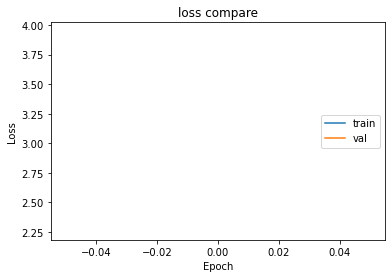

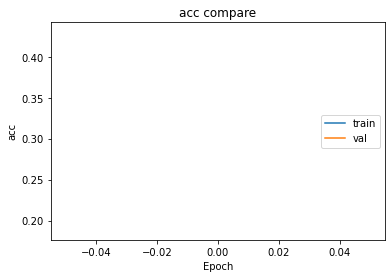

epoch = 2, lr = 0.001, momentum = 0.9, weight_decay = 0.005


225it [01:18,  2.87it/s]


train - loss: 1.703381489912669	, top1: 0.5733333428700765	, top5: 0.8814814885457357


25it [00:04,  6.11it/s]


valid - loss: 1.4227312898635864	, top1: 0.5666666428248087	, top5: 0.896666685740153


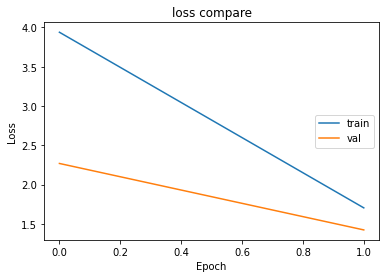

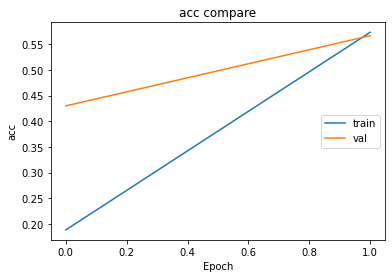

epoch = 3, lr = 0.001, momentum = 0.9, weight_decay = 0.005


225it [01:13,  3.06it/s]


train - loss: 0.8996688355339898	, top1: 0.7833333810170492	, top5: 0.9725925922393799


25it [00:04,  6.17it/s]


valid - loss: 1.1996670478582383	, top1: 0.6499999761581421	, top5: 0.9166666666666666


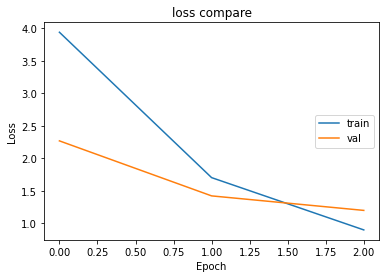

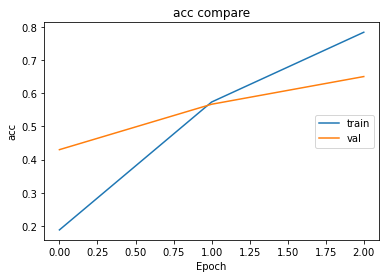

epoch = 4, lr = 0.001, momentum = 0.9, weight_decay = 0.005


225it [01:13,  3.07it/s]


train - loss: 0.5248074595795738	, top1: 0.9003703594207764	, top5: 0.9933333396911621


25it [00:03,  6.67it/s]


valid - loss: 1.0369692206382752	, top1: 0.703333298365275	, top5: 0.9333333174387614


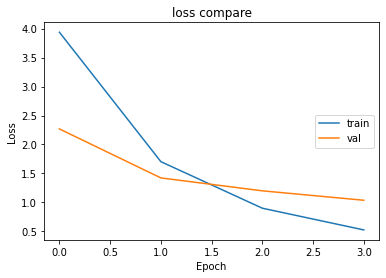

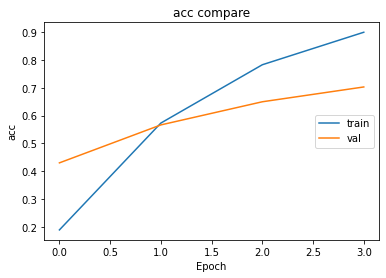

epoch = 5, lr = 0.001, momentum = 0.9, weight_decay = 0.005


225it [01:10,  3.19it/s]


train - loss: 0.33584944489929414	, top1: 0.9537037213643392	, top5: 0.9985185464223226


25it [00:03,  6.76it/s]


valid - loss: 0.987370661497116	, top1: 0.7133332888285319	, top5: 0.9433333079020182


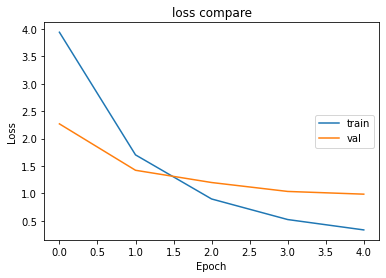

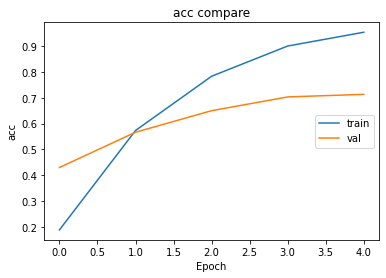

epoch = 6, lr = 0.0005, momentum = 0.9, weight_decay = 0.005


225it [01:10,  3.19it/s]


train - loss: 0.21529100727703837	, top1: 0.9792592525482178	, top5: 0.9996296564737955


25it [00:03,  6.80it/s]


valid - loss: 0.9106724262237549	, top1: 0.7400000095367432	, top5: 0.953333298365275


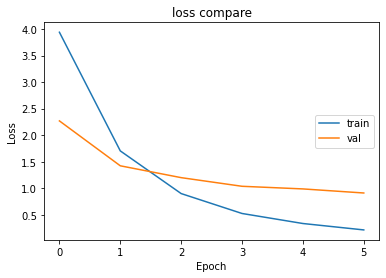

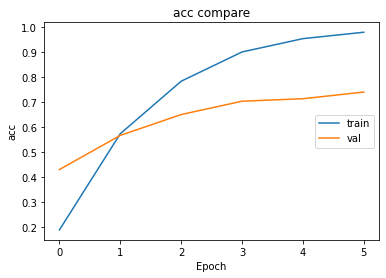

epoch = 7, lr = 0.0005, momentum = 0.9, weight_decay = 0.005


225it [01:09,  3.23it/s]


train - loss: 0.1634519716600577	, top1: 0.9896296660105387	, top5: 1.0


25it [00:03,  6.84it/s]


valid - loss: 0.9105805873870849	, top1: 0.7400000095367432	, top5: 0.9433333079020182


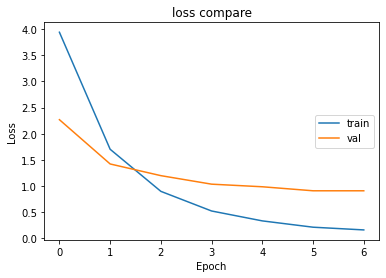

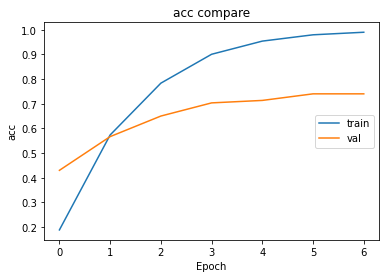

epoch = 8, lr = 0.0005, momentum = 0.9, weight_decay = 0.005


225it [01:09,  3.23it/s]


train - loss: 0.14474164401491482	, top1: 0.9907407760620117	, top5: 1.0


25it [00:03,  6.83it/s]


valid - loss: 0.8909324061870575	, top1: 0.753333330154419	, top5: 0.953333298365275


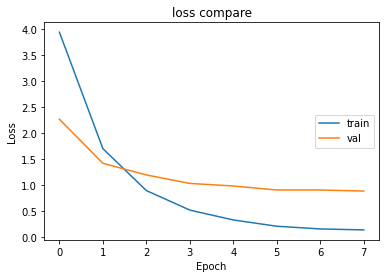

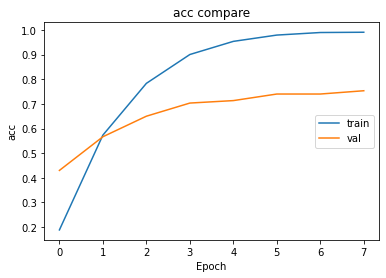

epoch = 9, lr = 0.0005, momentum = 0.9, weight_decay = 0.005


225it [01:09,  3.24it/s]


train - loss: 0.12315759595897463	, top1: 0.9937037626902262	, top5: 1.0


25it [00:03,  6.78it/s]


valid - loss: 0.8982269105315208	, top1: 0.7333333492279053	, top5: 0.9466666380564371


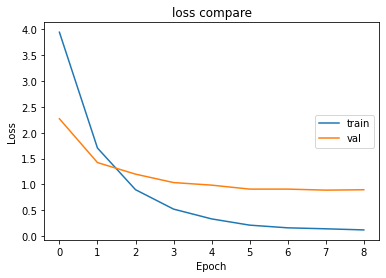

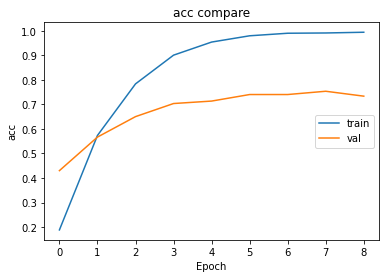

epoch = 10, lr = 0.0005, momentum = 0.9, weight_decay = 0.005


225it [01:10,  3.21it/s]


train - loss: 0.11278688091370795	, top1: 0.9948148727416992	, top5: 1.0


25it [00:03,  6.80it/s]


valid - loss: 0.9226969468593598	, top1: 0.7566666603088379	, top5: 0.9366666475931803


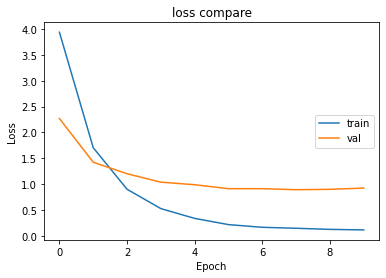

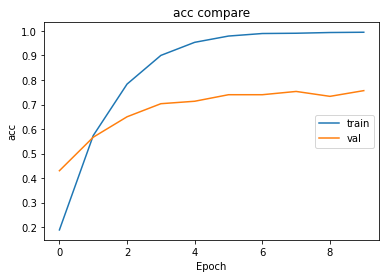

epoch = 11, lr = 0.00025, momentum = 0.9, weight_decay = 0.005


225it [01:10,  3.18it/s]


train - loss: 0.09610512427157826	, top1: 0.9985185464223226	, top5: 1.0


25it [00:03,  6.33it/s]


valid - loss: 0.9269470465183258	, top1: 0.7300000190734863	, top5: 0.9333333174387614


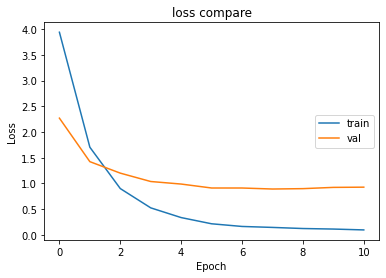

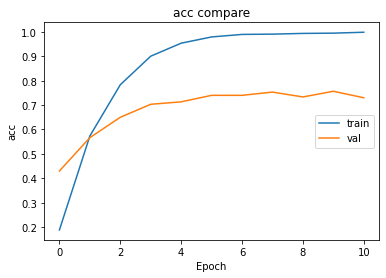

epoch = 12, lr = 0.00025, momentum = 0.9, weight_decay = 0.005


225it [01:13,  3.04it/s]


train - loss: 0.09375092446804047	, top1: 0.9981482028961182	, top5: 1.0


25it [00:04,  6.13it/s]

valid - loss: 0.922795991897583	, top1: 0.7266666889190674	, top5: 0.9399999777475992


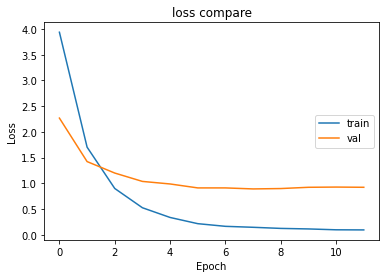

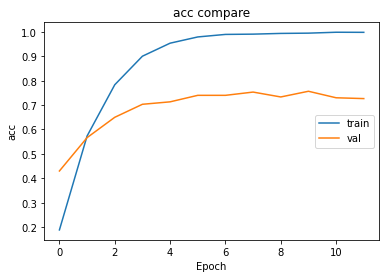

epoch = 13, lr = 0.00025, momentum = 0.9, weight_decay = 0.005


18it [00:06,  2.76it/s]


KeyboardInterrupt: 

In [9]:
if __name__ == "__main__":
    path = str(pathlib.Path().resolve())
    classes = getClasses()
    training_img_dir = path + '\\training_images\\'
    testing_img_dir = path + '\\testing_images\\'

    #print(dir(models))

    #model = factory.load_model('vit_base_patch16_224_miil_21k.pth')
    #model = factory.load_pretrained_vit_b_16()

    bird_dataset = birdDataset.myImageFloder(root='training_images/',
                                             label='training_labels.txt',
                                             transform=inference_transform)

    #model = factory.load_model('vit_base_patch16_224_miil_21k.pth')
    #model = torch.load('model/vit_b_16.pth')
    #model = factory.load_pretrained_vit_b_16()
    model = torch.load('model/vit_b_16_75percent.pth')

    training = False
    warmup = False
    epoch = 100
    iter = 0
    train_list = []
    train_acc_list = []
    val_list = []
    val_acc_list = []
    train_loss = 0.0
    val_loss = 0.0
    batch_size = 12
    warmup_lr = 1e-8
    #lr = 0.05
    #lr = 0.001
    lr = 0.001
    #momentum = 0.5
    momentum = 0.9
    #weight_decay = 0.05
    weight_decay = 0.005
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=lr,
                                momentum=momentum,
                                weight_decay=weight_decay)
    warmup_optimizer = torch.optim.SGD(model.parameters(),
                                       lr=warmup_lr,
                                       momentum=momentum,
                                       weight_decay=weight_decay)

    while (True):
        if (training == False):
            break

        iter += 1

        if ((iter <= 5) & (warmup == True)):
            print('epoch = ' + str(iter) + ', lr = ' + str(warmup_lr) +
                  ', momentum = ' + str(momentum) + ', weight_decay = ' +
                  str(weight_decay))

            tmp_train_loss, tmp_val_loss, train_acc_top1, valid_acc_top1 = train_and_valid(
                model,
                criterion,
                warmup_optimizer,
                bird_dataset,
                batch_size=batch_size)

            warmup_lr *= 10
            warmup_optimizer = torch.optim.SGD(model.parameters(),
                                       lr=warmup_lr,
                                       momentum=momentum,
                                       weight_decay=weight_decay)
        else:
            print('epoch = ' + str(iter) + ', lr = ' + str(lr) +
                  ', momentum = ' + str(momentum) + ', weight_decay = ' +
                  str(weight_decay))
            tmp_train_loss, tmp_val_loss, train_acc_top1, valid_acc_top1 = train_and_valid(
                model,
                criterion,
                optimizer,
                bird_dataset,
                batch_size=batch_size)

        train_list.append(tmp_train_loss)
        val_list.append(tmp_val_loss)
        train_acc_list.append(train_acc_top1)
        val_acc_list.append(valid_acc_top1)
        update_lost_hist(train_list,
                         val_list,
                         name='loss compare',
                         xlabel='Loss')
        update_lost_hist(train_acc_list,
                         val_acc_list,
                         name='acc compare',
                         xlabel='acc')
        #torch.save(model, 'model/vit_b_16_iter' + str(iter) + '.pth')
        if (iter == epoch):
            break
        if ((iter != 5) | (warmup != True)):
            if ((iter % 5) == 0):
                torch.save(model, 'model/vit_b_16_iter' + str(iter) + '.pth')
                lr /= 2
                optimizer = torch.optim.SGD(model.parameters(),
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay)

    test = True
    # Run model
    if (test == True):
        with torch.no_grad():
            run_image_classification(model, 'not use', inference_transform,
                                     classes)
